# DTSA 5511 Final Project

# Facial Keypoint Detection Through CNN With Data Augmentation

#### Tom Vo

#### 06/05/2023

In this project I am going to work through the [Facial Kepoints Detection Kaggle Competition](https://www.kaggle.com/competitions/facial-keypoints-detection/overview) and build a convolutional neural network (CNN) to perform facial recognition. I chose this project because I am very interested in computer vision. One day I want to develop AI guidance systems for spacecraft, and so the more exposure I get to various aspects of computer vision the better. My final for supervised learning (DTSA-5509) was a variety of supervised models that identified rice grains by species from images. My final for unsupervised learning was a variety of unsupervised models that identified pnuemonia from chest X-rays. In this project, I will use a supervised deep learning model to identify key features in faces. The benefit of working through a Kaggle competition is the ability to (1) learn from others who have submitted open-source code to the competition, and (2) get immediate feedback from Kaggle as to the performance of my model. 

Here is the general plan:

1) Download, Import, and Inspect the data

2) Clean the data

3) Perform EDA

4) Build an initial CNN, evaluate it against validation

5) Perform hyper parameter optimization to improve results

6) Submit best (by validation) CNN predictions to Kaggle

7) Debrief

Before running this notebook, please ensure that you have all the necessary libraries installed. Also please use a kernel with a GPU enabled, otherwise the training time will be overwhelming. Thank you for your time, and I hope you enjoy my project.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Flatten, Dropout
from keras.models import Sequential
from keras.layers import LeakyReLU
import os
import time

In [2]:
# Make sure that tensorflow sees the GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data Importation and Cleaning

Kaggle's wonderful API is an excellent method to get the data for this project if you are working on a local runtime. If you haven't already, to install the API just call "!pip install kaggle" in a new cell. Alternatively you can run a notebook through Kaggle's cloud computing resource, which has the benefit of allowing the user free access to GPU runtime. This is a good option if your graphics card is not compatible with TensorFlow. Before downloading the data, please ensure that your working directory is set how you'd like it for this project. I have mine in my DTSA-5511 homework directory. I'll manually unzip and place the data for this project in a folder called "data".

In [3]:
os.chdir("C:/Users/first/Desktop/DTSA_5511_HW/Final_Project/")
os.getcwd()

'C:\\Users\\first\\Desktop\\DTSA_5511_HW\\Final_Project'

In [4]:
!kaggle competitions download -c facial-keypoints-detection

facial-keypoints-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
#Confirm contents of "./data"
os.listdir("./data")

['.ipynb_checkpoints',
 'IdLookupTable.csv',
 'SampleSubmission.csv',
 'test',
 'train']

In [6]:
training_df = pd.read_csv("./data/train/training.csv")
testing_df = pd.read_csv("./data/test/test.csv")

### Basic Data Inspection:

Before we get into cleaning, let's look at the data size, data shape, and data types for our testing and training data. I'll use the os.path.size() function to look at the memory requirements for the data, the pd.DataFrame.head() method to provide an overview of the training and test data, and then a manual snip from the test.csv file to provide a more clear presentation of a cleaning concern.

In [7]:
training_df.head(1)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...


In [8]:
testing_df.head(1)

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...


In [9]:
print("The total memory requirement for the training data is:", os.path.getsize("./data/train/training.csv")/1e6, "MB")
print("The total memory requirement for the testing data is:", os.path.getsize("./data/test/test.csv")/1e6, "MB")

The total memory requirement for the training data is: 238.06481 MB
The total memory requirement for the testing data is: 59.822141 MB


The data for this project are very messy. The data encode greyscale images of faces, but are stored in .csv files which are not rectangular. We will need to clean them. Greyscale image data are generally encoded as values indicating the brightness of individual pixels. There is only one datum per pixel, unlike RGB images which require three dimensions per pixel. Unfortunately, the image data themselves are written as a single string sequence of numbers. Here is a snip of the test dataset for clarification:

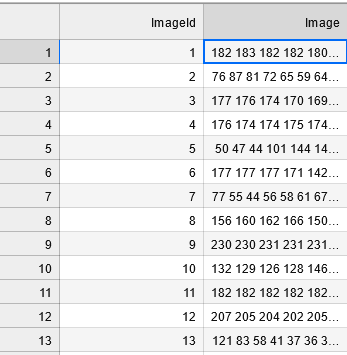

We will need to build a custom parser to turn the training and testing data into a numpy ndarray to feed to keras. The training dataset is a little bit more rectangular, because it also includes all the labels that we want to find. That said, it does still have the issue of requiring a parser for the image data. One side note: in general when doing computer vision a user is given a bunch of actual photos. A great library for converting photos to workable image data is cv2, whose imread and resize methods are fabulous conversion tools to get data into a numpy.ndarray.

Before we rectangularize the datasets, lets first check for null values in the training data. The pd.DataFrame.info() method is an excellent way to see where null values are in a data frame.

In [10]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

All but three of the columns in the training set have null values. Moreover, there are lots of features that only have values for $\frac{2271}{7049} \times 100\% = 32.2\%$ of their observations. The lack of labels would generally make these observations useless, but removing approximately seventy percent of our dataset is inane. We should instead use an imputation method. The pandas.fillna() method supplies us with a few different ways of imputing labels. We could either forward-fill or back-fill labels from the last/next valid observation using fillna(), which is akin to selecting a random legal value from the feature's probability density function. Another good method is to impute the mean value into each missing value.

When considering methods of imputation, it is critical to consider the modelling techniques that will be employed on the data. We will be feeding the training data into a CNN attatched to an ANN. A worst case scenario is that the ANN learns to simply predict the mean value for each imputed label because it was by far the most prevalent (mode) observation in the training set. As such in order to protect the diversity of our data, I will employ a back-fill imputation rather than a mean value imputation. After backfilling I will forward fill to take care of possible last-index missing value issues. One concern is that the missing values are not evenly spaced, and so we may have large counts of replicated labels. This is unlikely, but we can shuffle the data before imputing to avoid any potential issues with non-independent rows.

In [11]:
#Randomly shuffle rows, then reset row indecies
training_df.sample(frac=1).reset_index(drop=True)
#Impute missing values
#Citation https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html
training_df.fillna(method = "bfill", inplace = True)
training_df.fillna(method = "ffill", inplace = True)
#Count columns with the condition "is any element in the feature null?"
training_df.isnull().any().value_counts()

False    31
dtype: int64

We have succeeded in imputing random valid values into the training data. Now we need to fix the image data and load it into a numpy.ndarray for Keras. 

Cleaning note: within the image feature, there are missing values recorded as null characters, i.e. ''. To clean these I'll go ahead and map them to the mean value for a grayscale picture, 128. These missing values aren't common, so I'm not too concerned that the ANN will start just guessing 128.

In [12]:
def cleanImages(images_series : pd.Series) -> np.ndarray:
    # This function will be used on both the training and test image data to convert to np.ndarray
    startTime = time.time()
    imgs = list()
    
    for img in images_series:
        #Split the images using a space as seperator. split() returns a list.
        these_pix_chrs = img.split(" ")
        #Convert data type to float from character. We want float b/c we will be normalizing.
        these_pix_vals = [float(128) if j == "" else float(j) for j in these_pix_chrs]
        imgs.append(these_pix_vals)

    # Convert images from list to numpy.ndarray
    np_images = np.array(imgs)
    #shape =  (n_obs, 9216). 9216 is a perfect square b/c we have square images :) 
    ## We want one channel images to feed into Keras, ergo the following reshape:
    np_images = np_images.reshape((-1, 96, 96, 1))
    
    endTime = time.time()
    print("Total image conversion time:", round(endTime - startTime, 2), "seconds")
    
    return(np_images)

In [13]:
training_images = cleanImages(training_df["Image"])
print("The resulting numpy.ndarray for the training data has shape:", training_images.shape)

Total image conversion time: 80.36 seconds
The resulting numpy.ndarray for the training data has shape: (7049, 96, 96, 1)


In [14]:
testing_images = cleanImages(testing_df["Image"])
print("The resulting numpy.ndarray for the test data has shape:", testing_images.shape)

Total image conversion time: 22.38 seconds
The resulting numpy.ndarray for the test data has shape: (1783, 96, 96, 1)


The last piece of cleaning to do is to extract the keypoints into a parallel numpy.ndarray to overlay the training images. We only need to do this for the training data, but I'll put it in a function anyways for future projects with similarly messy data.

In [15]:
def getKeypoints(training_data : pd.DataFrame) -> np.ndarray:
    #Extract keypoints from training data
    ## The keypoint features are all features in the training dataset that aren't the image data
    startTime = time.time()
    training_data = training_data.drop("Image", axis = 1)
    keypoints = list()
    
    for index, string_keypoints in training_data.iterrows():
        keypoints.append(string_keypoints)
        
    #Convert keypoints to float, and store in ndarray
    keypoints = np.array(keypoints, dtype = "float")
    endTime = time.time()
    print("Total keypoint extraction time:", round(endTime - startTime, 2), "seconds")
    
    return(keypoints)

In [16]:
training_keypoints = getKeypoints(training_df)
print("The resulting numpy.ndarray has shape:", training_keypoints.shape)

Total keypoint extraction time: 1.01 seconds
The resulting numpy.ndarray has shape: (7049, 30)


# EDA and Augmentation

While I do my data augmentation for my model, I will perform EDA to keep myself and my reader in-the-loop regarding what the images that I'm modelling actually look like. First, let's see a couple faces overlaid with keypoints from the training data.

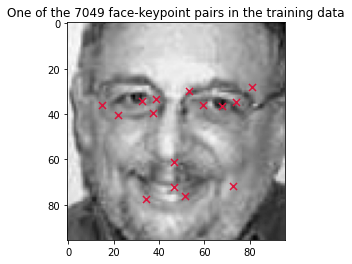

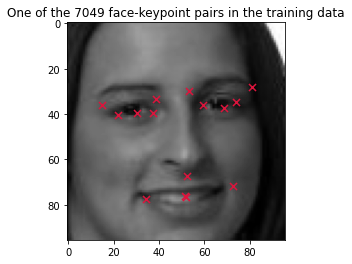

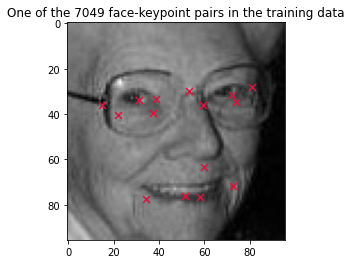

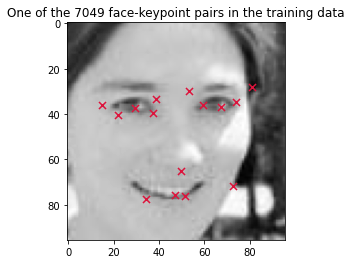

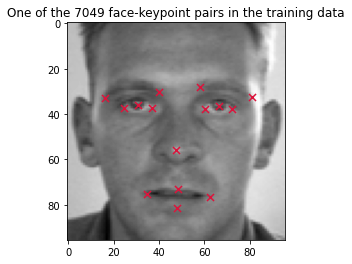

In [17]:
import random 

for i in range(5):
    idx = random.randrange(0, training_images.shape[0])
    fig, axis = plt.subplots()
    this_img = training_images[idx].reshape(96, 96)
    axis.imshow(this_img, cmap = "gray")
    axis.scatter(training_keypoints[idx][0::2], training_keypoints[idx][1::2], c = "crimson", marker = "x", s = 50)
    plt.title("One of the 7049 face-keypoint pairs in the training data")

Some of the keypoints are innacurate because they are imputed from other data (I'm looking at the first man, and the woman who is second to last in the printout above). Over the course of a huge number of training data and weight updates, hopefully these misses average out to an accurate prediction.

In lecture we learned that a good way to train a neural network to generalize the distribution of image data is to feed it different possible orientations of images it could recieve. People pose for photographs in many different positions, so we should make our model prepared for any orientation possible. Clarification - we will augment our dataset with rotations and translations of the initial dataset. As the images are rotated and translated, we will of course apply the same map to the keypoints. My decision to use this method was facilitated by Kaggle user "balraj98", who did a similar project with a rotation. His project is cited in my bibliography.

In [18]:
# Make image and keypoint rotation augmenter
# Augmentation functions thanks to Kaggle user balraj98
import cv2
import math

def rotationAugment(train_imgs : np.ndarray, train_keys : np.ndarray, rotationAngles : list):
    """
        This function rotates the inputs. We will use np.concatenate to augment the training data.
        The rotations performed are both clockwise and anticlockwise in degrees, read from rotationAngles. 
        
        Output: (np.ndarray rotated_imgs, np.ndarray rotated_keys)
    """
    rotated_imgs = list()
    rotated_keys = list()
    
    for abs_theta in rotationAngles:
        both_directions = [-abs_theta, abs_theta]
        for theta in both_directions:
            # Convert angle in degrees to radians. cv2 apparantly uses a non-conventional 
            ## rotation convention where clockwise is positive, so we need a negative.
            theta_in_radians = -1 * theta * math.pi / 180
            #Create rotation matrix for warpAffine
            R = cv2.getRotationMatrix2D((48, 48), theta, 1.0) 
            
            #Rotate all training images
            for img in train_imgs:
                this_rotated_img = cv2.warpAffine(img, R, (96, 96), flags = cv2.INTER_CUBIC)
                rotated_imgs.append(this_rotated_img)
            
            #Rotate all training keypoints
            for keypts in train_keys:
                # We cant just rotate every pixel against the cv2 MAT for the keypoints,
                ## so we will need to do this manually. First, we center the keypoints about 0.
                rotated = keypts - 48
                # Next we take advantage of some trigonometry to build a point-mapper.
                for index in range(0, len(rotated), 2):
                    rotated[index] = rotated[index] * math.cos(theta_in_radians) - rotated[index + 1] * math.sin(theta_in_radians)
                    rotated[index + 1] = rotated[index + 1] * math.cos(theta_in_radians) + rotated[index] * math.sin(theta_in_radians)
                    #Un-translate so we don't have negative x-vals for the keypoints
                rotated = rotated + 48
                
                rotated_keys.append(rotated)
    
    rotated_imgs = np.array(rotated_imgs)
    rotated_imgs = rotated_imgs.reshape(-1, 96, 96, 1)
    rotated_keys = np.array(rotated_keys)
    
    return (rotated_imgs, rotated_keys)

In [19]:
startTime = time.time()
# Perform rotation by -15, 15 degrees.
rotation_angles = [15]
(rotated_train_imgs, rotated_train_keypoints) = rotationAugment(training_images, training_keypoints, rotation_angles)

# The resulting dataframe will have 5 times as many observations as we started with.
## We will combine our training dataframes so that our translations will also have a 4/5 chance to
### be rotations.
training_images = np.concatenate((training_images, rotated_train_imgs))
print("After appending the rotations, the training images has shape:", training_images.shape)
training_keypoints = np.concatenate((training_keypoints, rotated_train_keypoints))
print("After appending the rotations, the training keypoints has shape:", training_keypoints.shape)

endTime = time.time()
print("Total rotation augmentation time:", round(endTime - startTime, 2), "seconds")

After appending the rotations, the training images has shape: (21147, 96, 96, 1)
After appending the rotations, the training keypoints has shape: (21147, 30)
Total rotation augmentation time: 12.97 seconds


#### Commentary:

For the sake of EDA, let's look at some of the new augmented training_images. There are now five copies of each image, with rotations on the set $\{-15, 0, 15\}$ degrees. Hopefully these mild rotations reflect what the model might encounter in the training data. As I did before, I'll pull five random photos to plot.

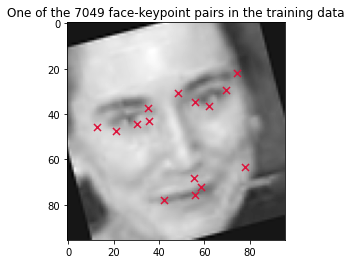

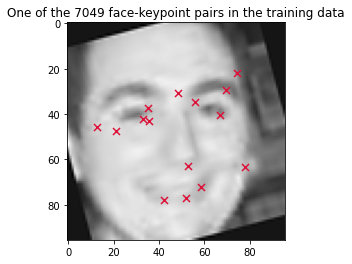

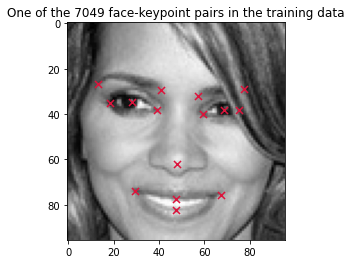

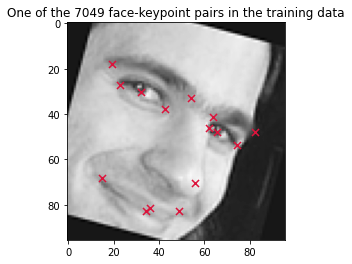

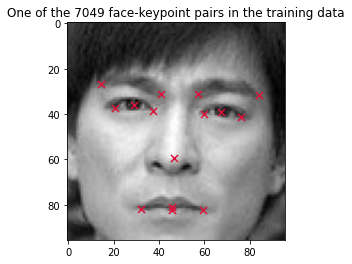

In [20]:
for i in range(5):
    idx = random.randrange(0, training_images.shape[0])
    fig, axis = plt.subplots()
    this_img = training_images[idx].reshape(96, 96)
    axis.imshow(this_img, cmap = "gray")
    axis.scatter(training_keypoints[idx][0::2], training_keypoints[idx][1::2], c = "crimson", marker = "x", s = 50)
    plt.title("One of the 7049 face-keypoint pairs in the training data")

Now I'll go ahead and apply affine translations to each image in training_data to further diversify it. There are a lot of different augmentations we could do on the data, but I think that rotation and translation in tandem is good enough for this project. Other possible augmentations include horizontal flips, reshading, and noising up the images. "balraj98" implements some of those in his project, and I would recommend checking that out if such augmentations are of interest.

In [21]:
def translationAugment(train_imgs : np.ndarray, train_keys : np.ndarray, translation_distances : list):
    """
        This function creates translated images. The input images train_imgs will be mapped d 
        pixels diagonally from their start position in each of four diagonal directions.
        Output: (np.ndarray translated_imgs, np.ndarray translated_keys)
    """
    translated_imgs = list()
    translated_keys = list()
    for d in translation_distances:
        #Translate in all four diagonal directions
        all_translations = [(-d, -d), (-d, d), (d, -d), (d, d)]
        for translation in all_translations:
            #Create image translation matrix for warpAffine
            T = np.array([[1, 0, translation[0]], [0, 1, translation[1]]], dtype = "float32")
            
            # This line courtesy of balraj. We can zip together train_imgs and train_keys
            ## to avoid the need for playing with indecies. Much cleaner than my initial implementation
            for (img, keypts) in zip(train_imgs, train_keys):
                this_translated_img = cv2.warpAffine(img, T, (96, 96), flags = cv2.INTER_CUBIC)
                
                """
                We want to translate the x_coordinate keypoints horizontally, and y_coordinate
                keypoints vertically. The even columned keypoints are x coordinates, while the
                odd columned keypoints are y coordinates. We can use the % operator:
                """
                these_translated_keypts = [(keypt + translation[0]) if (col_id % 2 == 0) else (keypt + translation[1]) for (col_id, keypt) in enumerate(keypts)]
                these_translated_keypts = np.array(these_translated_keypts)
                
                # We don't want translations that result in the keypoints being mapped outside of
                ## the (96, 96) grid, so we will filter any badly behaved translations out.
                if np.all(these_translated_keypts > 0.0) and np.all(these_translated_keypts < 96.0):
                    this_translated_img = this_translated_img.reshape(96, 96, 1)
                    translated_imgs.append(this_translated_img)
                    translated_keys.append(these_translated_keypts)
            
    return (translated_imgs, translated_keys)

In [22]:
startTime = time.time()
# Translate in all four legal diagonal directions by 15 pixels
dist = [15]
(translated_train_imgs, translated_train_keys) = translationAugment(training_images, training_keypoints, dist)

training_images = np.concatenate((training_images, translated_train_imgs))
print("After appending the rotations, the training images has shape:", training_images.shape)
training_keypoints = np.concatenate((training_keypoints, translated_train_keys))
print("After appending the rotations, the training keypoints has shape:", training_keypoints.shape)

endTime = time.time()
print("Total translation augmentation time:", round(endTime - startTime, 2), "seconds")

After appending the rotations, the training images has shape: (61323, 96, 96, 1)
After appending the rotations, the training keypoints has shape: (61323, 30)
Total translation augmentation time: 152.02 seconds


#### Commentary:

We now have a reasonable amount of training data to work with. We now have 61,323 training images to feed to our neural network. As I did after implementing the rotation augment, I'll show a random sampling of the data. Some amount less that 4/5 images will have some translation from the original, and exactly 2/3 images will have a rotation.

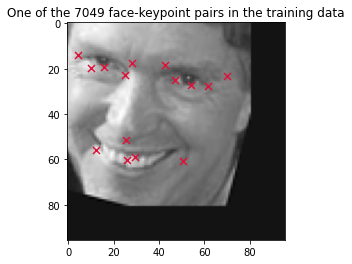

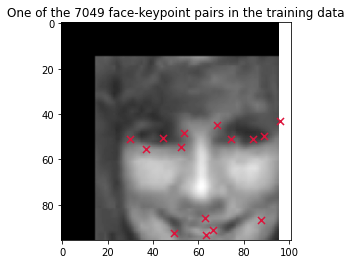

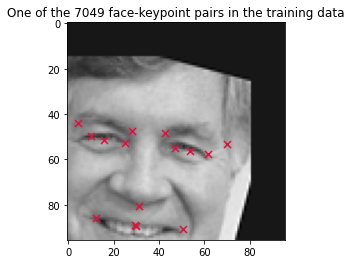

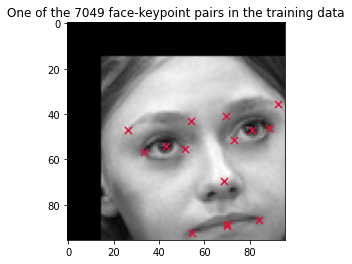

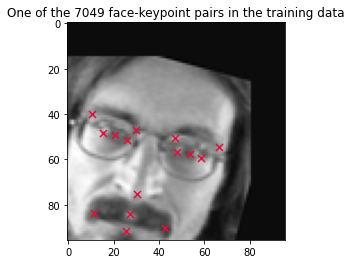

In [24]:
for i in range(5):
    idx = random.randrange(0, training_images.shape[0])
    fig, axis = plt.subplots()
    this_img = training_images[idx].reshape(96, 96)
    axis.imshow(this_img, cmap = "gray")
    axis.scatter(training_keypoints[idx][0::2], training_keypoints[idx][1::2], c = "crimson", marker = "x", s = 50)
    plt.title("One of the 7049 face-keypoint pairs in the training data")

As a last piece of cleaning, we will limit the amount of training data that the model encounters. We want to include all the "normal" images because they are most representative of what we are likely to encounter in the test set. I will include about 8000 augmented images, randomly selected as well.

In [37]:
#Citation https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison

n_augmented_samples = 15000 - 7049
normal_imgs = training_images[:7049, :, :, :]
normal_keypts = training_keypoints[:7049, :]
augmented_indecies = [i for i in range(7049, training_images.shape[0])]
p = np.random.permutation(augmented_indecies)
augmented_imgs = training_images[p, :, :, :]
augmented_keypts = training_keypoints[p, :]

training_images = np.concatenate((normal_imgs, augmented_imgs[:n_augmented_samples, :, :, :]))
training_keypoints = np.concatenate((normal_keypts, augmented_keypts[:n_augmented_samples, :]))

In [38]:
print("The final training image set has shape:", training_images.shape)
print("The final training keypoint set has shape:", training_keypoints.shape)

The final training image set has shape: (15000, 96, 96, 1)
The final training keypoint set has shape: (15000, 30)


# Model Architecture and Construction:

The model I will use to predict keypoints will have two components - a feature extractor in the form of a CNN, and a label-maker in the form of Dense ANN. In class we learned that the standard method of creating a convolutional feature extractor is to have iterations of three layers:

$$[\text{Convolve}, \text{Convolve}, \text{MaxPool}]_n$$

This set of three layers is then repeated a pre-specified number of times. This choice of architecture is a hyperparameter which must be optimized. In a convolution layer, pixels around a central pixel are included in a straightforward mathematical operation, and then the resulting value is stored as a weight corresponding to the initial pixel. This process is then repeated for all pixels on the input image. The MaxPool operation acts as a filter to help "blur" local features for future convolution layers - this helps pick up global features and helps deal with noisy images. As the iteration of [C, C, MP] increases, the later convolution layers will pull from "farther" features with respect to the original image, because they will be performing convolution on already convolved features, which were in turn functions of local features. Functions of many local features become a more global feature. We are working with images of faces, so we want the ANN to "see" the entire photo before assigning key points.

In order to prevent the weights from diverging, I'll put BatchNormalization layers after each convolution layer. A batch normalization layer maps an input to a Standard Normal variable, on which we do convolution math. Smaller and more balanced values are good when working with addition and multiplication.

I will try several different architectures with several different learning rates as my hyper parameter optimization process for this project. In order to cut down on training time, I will just use the, "Adam" optimizer, though another good optimizer available in the Keras library is "RMSprop". Feel free to try that one instead and compare results.

#### Initial Model:

I'll use 4 [C, C, MP] iterations to start with, each with twice more filters that the previous layer. I'll use LeakyReLU activations because our Professor noted that it allow more diversity in output for negative valued inputs. LeakyReLU takes a hyperparameter $\alpha$, which I'll play with after I have my architecture picked.

In [39]:
def makeCNN(initial_eta : float, initial_filter_num : int, num_CCMP_layers : int):
    """
        This function creates and compiles, but does not train, a CNN -> ANN model to
        process the training data and predict keypoints. 
        Input: 
            learning rate initial_eta, strictly greater than 0
            intial filter count initial_filter_num, should be multiple of 2
            number of C-C-MP iterations, must be 1 <= k <= 5
        Output: 
            Compiled keras.Sequential model
    """
    #Set initial HP's
    in_shape = (96, 96, 1)
    pad = "same"
    ker_size = 3
    cntr = 2
    
    # Initialize model
    model = Sequential()
    
    #Add initial C-C-MP layer
    model.add(Conv2D(initial_filter_num, ker_size, padding = pad, input_shape = in_shape, use_bias = False))
    model.add(LeakyReLU()) # Can try diff values for slope
    model.add(BatchNormalization())
    model.add(Conv2D(initial_filter_num, ker_size, padding = pad, use_bias = False))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    
    #Add the desired number of C-C-MP layers
    for layer in range(num_CCMP_layers - 1):
        model.add(Conv2D(cntr*initial_filter_num, ker_size, padding = pad, use_bias = False))
        model.add(LeakyReLU())
        model.add(BatchNormalization())
        model.add(Conv2D(cntr*initial_filter_num, ker_size, padding = pad, use_bias = False))
        model.add(LeakyReLU())
        model.add(BatchNormalization())
        model.add(MaxPooling2D())
        cntr *= 2
    
    #Add ANN for keypoint assignment
    ANN_width = model.layers[-1].output_shape[3]
    model.add(Flatten())
    model.add(Dense(ANN_width, activation = "relu"))
    model.add(Dropout(0.15))
    model.add(Dense(30, activation = "relu")) #We are doing regression
    
    #Add learning rate scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate = initial_eta,
      decay_steps = 1000,
      decay_rate=0.9
    ) 
    
    #Compile model with appropriate callbacks
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule),
        loss = "mean_squared_error",
        metrics = ["acc", "mae"]
    )
        
    return(model)

In [40]:
# Fit initial model as sanity check before performing grid search over H.P.'s
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5, mode = "min")]

testModel = makeCNN(1e-3, 16, 3)
testHistory = testModel.fit(training_images, training_keypoints,
                            validation_split = 0.08,
                            epochs = 5,
                            batch_size = 32,
                            callbacks = callbacks_list,
                            verbose = 2
                           )

Epoch 1/5
432/432 - 26s - loss: 268.7705 - acc: 0.2630 - mae: 10.4322 - val_loss: 117.6670 - val_acc: 0.5033 - val_mae: 8.9865 - 26s/epoch - 61ms/step
Epoch 2/5
432/432 - 7s - loss: 61.6272 - acc: 0.3943 - mae: 5.9686 - val_loss: 45.3246 - val_acc: 0.5433 - val_mae: 5.5386 - 7s/epoch - 17ms/step
Epoch 3/5
432/432 - 7s - loss: 48.9173 - acc: 0.4574 - mae: 5.2758 - val_loss: 21.1133 - val_acc: 0.6117 - val_mae: 3.4104 - 7s/epoch - 16ms/step
Epoch 4/5
432/432 - 7s - loss: 43.4597 - acc: 0.5067 - mae: 4.9428 - val_loss: 26.9383 - val_acc: 0.5475 - val_mae: 3.9368 - 7s/epoch - 16ms/step
Epoch 5/5
432/432 - 7s - loss: 40.5227 - acc: 0.5386 - mae: 4.7457 - val_loss: 19.5728 - val_acc: 0.5667 - val_mae: 3.4294 - 7s/epoch - 17ms/step


#### Commentary:

The model works! It's pretty bouncy in terms of validation loss though, so we may need to use a different set of callbacks rather than just a patience argument. I'll use a checkpointer so that we don't store worse iterations of the model. Now that we have an initial model up, we can start performing hyperparameter optimization. I'll check values of $\eta$ on the set $\{10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}\}$. We could really spend a large amount of computation time optimizing $\eta$, but considering how long one training cycle takes it doesn't seem worthwhile. 

I will also optimize the number of [C-C-MP] layers, which can take values between 1 and 5 before the convolution space becomes odd (3 X 3) and can't be properly MaxPooled with a 2X2 filter.

Instead of doing a grid search, I'll use a greedy algorithm for my hyperparameter search. While the greedy algorithm has no guarentee of finding the global minimum for loss, it will find a local minimum, which is good enough for a Kaggle competition. The greedy algorithm will be orders of magnitude more computationally efficient than a true grid search. 

In [41]:
# Optimize over learning rate
eta_to_try = [1e-5, 1e-4, 1e-3, 1e-2]
#callbacks_list = [tf.keras.callbacks.ModelCheckpoint(filepath = './tmp/checkpoint', monitor = "val_mae", verbose = 0, save_best_only = True, mode = "min")]
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 15, mode = "min")]

startTime = time.time()
current_best = (None, float("inf"), None)
for eta in eta_to_try:
    #Make and train model
    print("Now fitting model with eta =", eta)
    this_model = makeCNN(eta, 16, 3)
    this_history = this_model.fit(training_images, training_keypoints,
                                validation_split = 0.08,
                                epochs = 100,
                                batch_size = 32,
                                callbacks = callbacks_list,
                                verbose = 0
                               )
    #Save current model if it has a better last validation loss than the current best
    if this_history.history["val_loss"][-1] < current_best[1]:
        current_best = (this_history, this_history.history["val_loss"][-1], eta)
    
endTime = time.time()
print("Total learning rate optimization time:", round((endTime - startTime)/60, 2), "minutes")
print("Optimal learning rate was:", current_best[2])

Now fitting model with eta = 1e-05
Now fitting model with eta = 0.0001


KeyboardInterrupt: 

In [ ]:
# Optimize over number of C-C-MP layers
CCMP_to_try = [1, 2, 3, 4, 5]
startTime = time.time()
current_best = (None, float("inf"), None)
for CCMP in CCMP_to_try:
    #Make and train model
    print("Now fitting model with", CCMP, "C-C-MP layer(s)")
    this_model = makeCNN(0.001, 16, CCMP)
    this_history = this_model.fit(training_images, training_keypoints,
                                validation_split = 0.08,
                                epochs = 100,
                                batch_size = 32,
                                callbacks = callbacks_list,
                                verbose = 0
                               )
    #Save current model if it has a better last validation loss than the current best
    if this_history.history["val_loss"][-1] < current_best[1]:
        current_best = (this_history, this_history.history["val_loss"][-1], CCMP)

endTime = time.time()
print("Total C-C-MP layer count optimization time:", round((endTime - startTime)/60, 2), "minutes")
print("Optimal C-C-MP layer count rate was:", current_best[2])

In [ ]:
# Optimize over initial filter sizes
size_to_try = [8, 16, 32, 64]
startTime = time.time()
current_best = (None, float("inf"), None)
for size in size_to_try:
    #Make and train model
    print("Now fitting model with", size,  "initial filters")
    this_model = makeCNN(0.001, size, 3)
    this_history = this_model.fit(training_images, training_keypoints,
                                validation_split = 0.08,
                                epochs = 100,
                                batch_size = 32,
                                callbacks = callbacks_list,
                                verbose = 0
                               )
    #Save current model if it has a better last validation loss than the current best
    if this_history.history["val_loss"][-1] < current_best[1]:
        current_best = (this_history, this_history.history["val_loss"][-1], size)

endTime = time.time()
print("Total initial filter count optimization time:", round((endTime - startTime)/60, 2), "minutes")
print("Optimal initial filter count was:", current_best[2])

In [ ]:
print("Here's the architecture summary for the best performing model by validation loss:")
print(current_best[0].model.summary())

#### Optimization Note:

I ran a grid search with 10,000 randomly selected data points, then upon re-load with 15,000 the kernel took too long to evaluate so I keyboard-interupted. My greedy grid search returned the following hyperparameters: learning rate = 0.001, number of C-C-MP layers = 3, and number of initial filters = 32. If you run this notebook and get different H.P.'s please let me know. I'll go ahead and train our model with those hyperparams.

In [42]:
startTime = time.time()
optimal_model = makeCNN(0.001, 32, 3)
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 15, mode = "min")]
optimal_history = optimal_model.fit(training_images, training_keypoints,
                        validation_split = 0.08,
                        epochs = 100,
                        batch_size = 32,
                        callbacks = callbacks_list,
                        verbose = 0
                        )
print("Here's the model summary for the optimal model:")
print(optimal_history.model.summary())
endTime = time.time()
print("Total training time for optimal model was:", round((endTime - startTime)/60, 2), "minutes")

Here's the model summary for the optimal model:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 96, 96, 32)        288       
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 96, 96, 32)        0         
                                                                 
 batch_normalization_18 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_19 (Conv2D)          (None, 96, 96, 32)        9216      
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 96, 96, 32)        0         
                                                                 
 batch_normalization_19 (Bat  (None, 96, 96, 32)       128       
 chNor

# Results and Analysis:

First thing's first, let's make some graphics to visualize how well the model performed on the training and validation data. After that, we'll generate predictions on the test set and submit them to Kaggle for a score. 

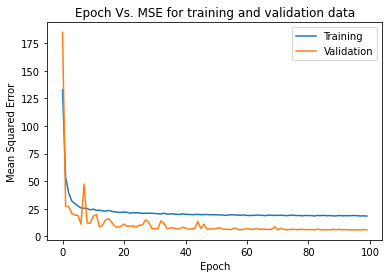

In [43]:
# Plot MSE and Val_MSE vs. Epoch
plt.plot(optimal_history.history["loss"])
plt.plot(optimal_history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("Epoch Vs. MSE for training and validation data")
plt.legend(["Training", "Validation"])
plt.show()

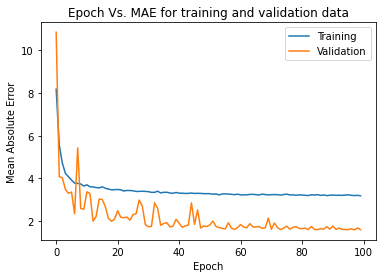

In [45]:
# Plot MAE and Val_MAE vs. Epoch
plt.plot(optimal_history.history["mae"])
plt.plot(optimal_history.history["val_mae"])
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.title("Epoch Vs. MAE for training and validation data")
plt.legend(["Training", "Validation"])
plt.show()

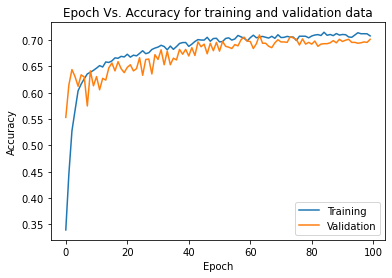

In [46]:
# Plot Accuracy and Val_Accuracy Vs. Epoch
plt.plot(optimal_history.history["acc"])
plt.plot(optimal_history.history["val_acc"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch Vs. Accuracy for training and validation data")
plt.legend(["Training", "Validation"])
plt.show()

#### Commentary: 

One note on the plots: the accuracy is only recorded as a "hit" if the model outputs the exact correct pixel for the keypoint. The keypoint labels are pretty fuzzy to begin with, and a bunch of the labels were imputed from other data. A final accuracy of about 70% is quite good for pixel perfect assignments. The MAE and MSE are more reasonable statistics to worry about, because they indicate how close the model is to the target - they are proper minimizable loss functions.  The MAE and MSE both begin to asymptote down for the validation data due to the learning rate scheduling, which is very desirable. The MAE for the model was just about 2 pixels at the end of training, which is quite good. We probably could have let the training continue because none of the validation metrics had begun to fall off by the time training ended. The total training time was already 20 minutes though, and I didn't want to mess with optimizing number of epochs. Let's generate some predictions and submit to Kaggle.

56/56 [==============================] - 1s 12ms/step
Sanity check - the predicted keypoints have shape: (1783, 30)


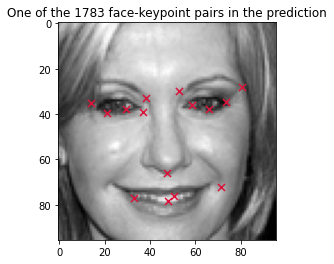

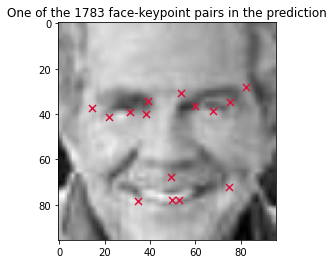

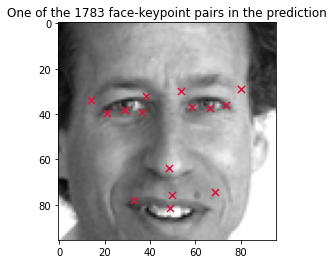

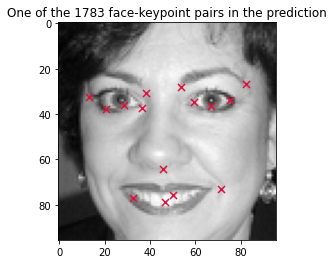

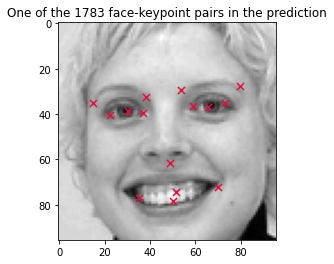

In [49]:
pred_keypoints = optimal_history.model.predict(testing_images)
print("Sanity check - the predicted keypoints have shape:", pred_keypoints.shape)
# Visualize the predictions
for i in range(5):
    idx = random.randrange(0, testing_images.shape[0])
    fig, axis = plt.subplots()
    this_img = testing_images[idx].reshape(96, 96)
    axis.imshow(this_img, cmap = "gray")
    axis.scatter(pred_keypoints[idx][0::2], pred_keypoints[idx][1::2], c = "crimson", marker = "x", s = 50)
    plt.title("One of the 1783 face-keypoint pairs in the prediction")

It looks like our model is very good at recognizing eyes and eyebrows, but not so great at noses or the boundaries of mouths. Weird. If we used more training data (not just 15000) we would have a better result. We also might get a better result by dropping all photos without clean rows instead of imputing data. Let's submit these results to Kaggle for a test score, then compare our results against a supervised model - I'll use a Random Forest.

In [61]:
# Numpy to Pandas prediction converter thanks to Kaggle user "karanjakhar"
feature_names = list(idlookup_df['FeatureName'])
image_ids = list(idlookup_df['ImageId']-1)
row_ids = list(idlookup_df['RowId'])

feature_list = []
for feature in feature_names:
    feature_list.append(feature_names.index(feature))
    
predictions = []
for x,y in zip(image_ids, feature_list):
    predictions.append(pred_keypoints[x][y])
    
row_ids = pd.Series(row_ids, name = 'RowId')
locations = pd.Series(predictions, name = 'Location')
locations = locations.clip(0.0,96.0)
submission_result = pd.concat([row_ids,locations],axis = 1)
submission_result.to_csv('./CNN_Predictions.csv',index = False)

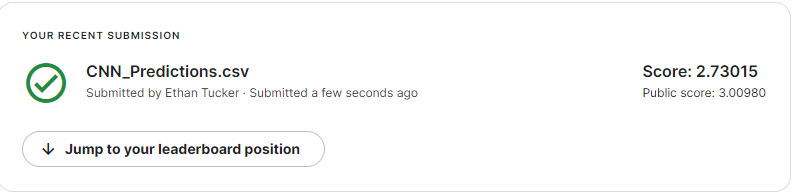

Although the competiton is closed, we can see where my model would have been ranked if it were not:

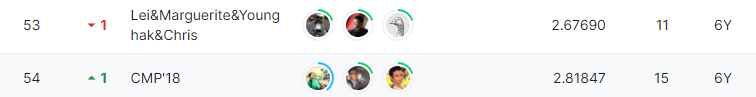

The model would have been ranked 54/175, which is the 69th percentile. For my first attempt at facial recognition, that's pretty reasonable. Let's implement a quick and dirty Random Forest to compare against.

### Random Forest

This will likely take about an hour to train, so run at your own peril. Also, please either ensure you have 8 devotable cores to the random forest, or adjust n_jobs to whatever is acceptable on your machine.

In [70]:
from sklearn.ensemble import RandomForestRegressor
startTime = time.time()
forest_train_data = training_images.reshape(training_images.shape[0], 96 * 96)
forest_test_data = testing_images.reshape(testing_images.shape[0], 96 * 96)
reg = RandomForestRegressor(n_estimators = 100,
                            max_depth = 3,
                            random_state = 42,
                            n_jobs = 8
                           )
reg.fit(forest_train_data, training_keypoints)

RF_preds = reg.predict(forest_test_data)
endTime = time.time()
print("Total random forest regressor training time was", round((endTime - startTime)/60, 2), "minutes")

Total random forest regressor training time was 8.54 minutes


Sanity check - the predicted keypoints have shape: (1783, 30)


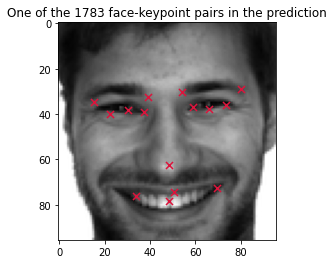

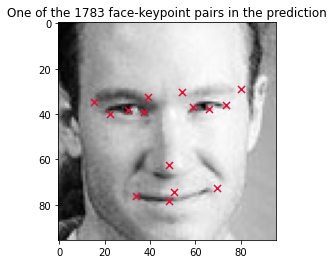

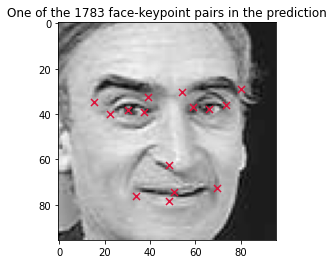

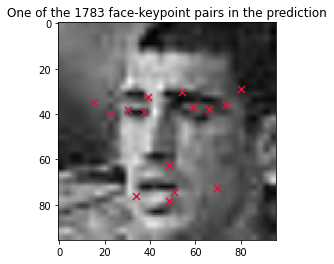

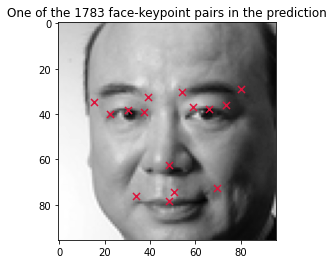

In [72]:
# Visualize predictions from random forest regressor
print("Sanity check - the predicted keypoints have shape:", RF_preds.shape)
# Visualize the predictions
for i in range(5):
    idx = random.randrange(0, testing_images.shape[0])
    fig, axis = plt.subplots()
    this_img = testing_images[idx].reshape(96, 96)
    axis.imshow(this_img, cmap = "gray")
    axis.scatter(RF_preds[idx][0::2], RF_preds[idx][1::2], c = "crimson", marker = "x", s = 50)
    plt.title("One of the 1783 face-keypoint pairs in the prediction")

#### Commentary:

It seems like the random forest just makes the same predictions every time. This basically a null model, where we just guess the mean value of each feature. Such a prediction is essentially useless for facial recognition. The neural network is therefore heavily preferred for decision making. We could try to increase the random forest size, but accuracy is not likely to converge nearly as fast as the neural network. I'd rather spend computation time improving the neural net.

# Conclusion

This project served as a personal introduction to facial recognition. I built a convolutional neural network as a feature extractor, then attached it to an artificial neural network as a regressor for facial key points. The network performed well in identifying eyes and eyebrows, but it was somewhat inaccurate in locating the tips of noses and the boundaries of mouths. This inaccuracy may have been due to the different ways people pose for photographs. Sometimes people smile, and sometimes they close their mouths. However, people generally always have their eyes open when their picture is taken.

Another source of error may have originated from my feature imputation method. The data from the Kaggle competition was quite messy - out of the approximately 7000 images, only about 2000 were fully populated with all features. I chose to impute features pseudo-randomly by back-filling and then forward-filling from the most recent valid observation of the feature. This approach may have introduced significant errors, particularly in mouth detection. A good follow-up project would be to repeat the experiment using more augmented photos from clean rows, instead of using all rows and augmenting dirty data.

While the neural network wasn't perfect, it still performed very well. I compared my AI to a random forest regressor as the final stage of my project. The random forest model utterly failed to generate adaptive keypoints based on the images it was shown. It appears that the random forest just guessed the mean value of each feature for each image, essentially acting as a null model. The neural network could be improved in the future by increasing the training times, using more augmented data, and applying a wider variety of augmentations.

# References:

1) [Missing Value Imputation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)

2) [Image Data Augmentation](https://www.kaggle.com/code/balraj98/data-augmentation-for-facial-keypoint-detection)

3) [Easy Facial Keypoint Detection](https://www.kaggle.com/code/karanjakhar/facial-keypoint-detection)

4) [Model Checkpointing](https://keras.io/api/callbacks/model_checkpoint/)

5) [Shuffling numpy arrays be common permutation](https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison)




In [1]:
# Print system information for replication
import platform
print(platform.machine())
print(platform.version())
print(platform.platform())
print(platform.uname())
print(platform.system())
print(platform.processor())

AMD64
10.0.19044
Windows-10-10.0.19044-SP0
uname_result(system='Windows', node='MSI', release='10', version='10.0.19044', machine='AMD64')
Windows
Intel64 Family 6 Model 141 Stepping 1, GenuineIntel
